In [1]:
require 'torch'

os.execute('wget -c http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz')
os.execute('tar -xvf cifar-10-binary.tar.gz')
local function convertCifar10BinToTorchTensor(inputFnames, outputFname)
   local nSamples = 0
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      assert(nSamplesF == math.floor(nSamplesF), 'expecting numSamples to be an exact integer')
      nSamples = nSamples + nSamplesF
      m:close()
   end

   local label = torch.ByteTensor(nSamples)
   local data = torch.ByteTensor(nSamples, 3, 32, 32)

   local index = 1
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      m:seek(1)
      for j=1,nSamplesF do
         label[index] = m:readByte()
         local store = m:readByte(3072)
         data[index]:copy(torch.ByteTensor(store))
         index = index + 1
      end
      m:close()
   end

   local out = {}
   out.data = data
   out.label = label
   print(out)
   torch.save(outputFname, out)
end

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/data_batch_1.bin',
                                'cifar-10-batches-bin/data_batch_2.bin',
                                'cifar-10-batches-bin/data_batch_3.bin',
                                'cifar-10-batches-bin/data_batch_4.bin',
                                'cifar-10-batches-bin/data_batch_5.bin'},
   'cifar10-train.t7')

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/test_batch.bin'},
   'cifar10-test.t7')

cifar-10-batches-bin/
cifar-10-batches-bin/data_batch_1.bin


cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin


cifar-10-batches-bin/data_batch_4.bin


cifar-10-batches-bin/test_batch.bin


cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin


cifar-10-batches-bin/data_batch_2.bin


{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}


{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [2]:
require 'nn';
require 'paths'
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [3]:
trainset.label = trainset.label+1
testset.label = testset.label+1

In [4]:
-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(testset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
testset.data = testset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function testset:size() 
    return self.data:size(1) 
end

In [5]:
r = trainset.data[{ {}, {1}, {}, {}  }]*0.21
g = trainset.data[{ {}, {2}, {}, {}  }]*0.72
b = trainset.data[{ {}, {3}, {}, {}  }]*0.07
trainset.data = r+g+b
r = testset.data[{ {}, {1}, {}, {}  }]*0.21
g = testset.data[{ {}, {2}, {}, {}  }]*0.72
b = testset.data[{ {}, {3}, {}, {}  }]*0.07
testset.data = r+g+b

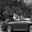

automobile	
2	


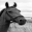

horse	
8	


In [6]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])
print(trainset.label[100])
itorch.image(testset.data[100]) -- display the 100-th image in dataset
print(classes[testset.label[100]])
print(testset.label[100])

In [7]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,1 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future

Channel 1, Mean: 122.80931339391	


Channel 1, Standard Deviation: 61.229392750446	


In [8]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax(1)) 

In [9]:
criterion = nn.ClassNLLCriterion()

In [10]:
require 'cunn';
require 'cutorch';
cutorch.setDevice(2)
print(cutorch.getDevice())

2	


In [11]:
net = net:cuda()

In [12]:
criterion = criterion:cuda()

In [13]:
targets=trainset.label:long()
one_hot_train = torch.eye(10):index(1, targets)
--targets=testset.label:long()
--one_hot_test = torch.eye(10):index(1, targets)

In [14]:
trainset.data = trainset.data:cuda()
--trainset.label = one_hot_train:cuda()
trainset.label = trainset.label:cuda()
testset.data = testset.data:cuda()
testset.label = testset.label:cuda()

In [15]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.01
trainer.maxIteration = 1 -- just do 5 epochs of training.

In [ ]:
tstart=os.time()
trainer:train(trainset)
tend=os.time()
print(os.difftime (tend , tstart))

# StochasticGradient: training	


In [20]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end
print(correct, 100*correct/10000 .. ' % ')

3447	34.47 % 	


In [26]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	53.4 %	
automobile	40.9 %	
bird	7 %	
cat	63.9 %	
deer	1.1 %	
dog	32.6 %	
frog	13 %	
horse	35.6 %	
ship	58 %	
truck	39.3 %	


In [16]:
parameters, gradParameters = net:getParameters()

In [21]:
dl = require 'dataload'
optim = require 'optim';
one_hot = torch.eye(10):index(1, targets)
dataloader = dl.TensorLoader(trainset.data, trainset.label)
i=0
batch_size=1000
epochs=100

-- Define SGD parameters.
sgd_params = {
    learningRate = 0.1,
    weightDecay = 0,
    momentum = 0.5
}
tstart=os.time()
for j=1,epochs do
    print("------ epoch - " ..j.. " ----- ")
    tot_loss=0
    for k, inputs, targets in dataloader:subiter(batch_size,50000) do
        -- Define a closure that computes the loss and dloss/dx.
        feval = function()
            -- reset gradients
            gradParameters:zero()
            output=net:forward(inputs)
            loss=criterion:forward(output, targets)
            gradients = criterion:backward(output, targets)
            net:backward(inputs, gradients)
            return loss, gradParameters
        end
        _,local_loss = optim.sgd(feval, parameters, sgd_params)
        tot_loss = tot_loss + local_loss[1]
    end
    print("------- loss - " ..(tot_loss/50).. " ------ ")
end

tend=os.time()
print("------ Time taken :",os.difftime (tend , tstart))

------ epoch - 1 ----- 	


------- loss - 10.605719903708 ------ 	
------ epoch - 2 ----- 	


------- loss - 9.0273423564434 ------ 	
------ epoch - 3 ----- 	


------- loss - 8.4805366933346 ------ 	
------ epoch - 4 ----- 	


------- loss - 8.0844659739733 ------ 	
------ epoch - 5 ----- 	


------- loss - 7.7680968660116 ------ 	
------ epoch - 6 ----- 	


------- loss - 7.4988136720657 ------ 	
------ epoch - 7 ----- 	


------- loss - 7.2781827294827 ------ 	
------ epoch - 8 ----- 	


------- loss - 7.0941875141859 ------ 	
------ epoch - 9 ----- 	


------- loss - 6.855348200202 ------ 	
------ epoch - 10 ----- 	


------- loss - 6.7410977965593 ------ 	
------ epoch - 11 ----- 	


------- loss - 6.5618409121037 ------ 	
------ epoch - 12 ----- 	


------- loss - 6.4015192842484 ------ 	
------ epoch - 13 ----- 	


------- loss - 6.2881452041864 ------ 	
------ epoch - 14 ----- 	


------- loss - 6.1762988770008 ------ 	
------ epoch - 15 ----- 	


------- loss - 5.993175149858 ------ 	
------ epoch - 16 ----- 	


------- loss - 5.9487379294634 ------ 	
------ epoch - 17 ----- 	

------- loss - 5.8985304111242 ------ 	
------ epoch - 18 ----- 	


------- loss - 5.7990435349941 ------ 	
------ epoch - 19 ----- 	


------- loss - 5.6787304770946 ------ 	
------ epoch - 20 ----- 	


------- loss - 5.6575275021791 ------ 	
------ epoch - 21 ----- 	


------- loss - 5.561338468194 ------ 	
------ epoch - 22 ----- 	


------- loss - 5.5435123962164 ------ 	
------ epoch - 23 ----- 	


------- loss - 5.3836343294382 ------ 	
------ epoch - 24 ----- 	


------- loss - 5.321825517416 ------ 	
------ epoch - 25 ----- 	


------- loss - 5.2977972626686 ------ 	
------ epoch - 26 ----- 	


------- loss - 5.2327437478304 ------ 	
------ epoch - 27 ----- 	


------- loss - 5.1259099209309 ------ 	
------ epoch - 28 ----- 	


------- loss - 5.1925744065642 ------ 	
------ epoch - 29 ----- 	


------- loss - 5.1854295367002 ------ 	
------ epoch - 30 ----- 	


------- loss - 5.1079594430327 ------ 	
------ epoch - 31 ----- 	


------- loss - 5.0502288267016 ------ 	
------ epoch - 32 ----- 	


------- loss - 4.9577088588476 ------ 	
------ epoch - 33 ----- 	


------- loss - 4.9618208163977 ------ 	
------ epoch - 34 ----- 	


------- loss - 4.7953096219897 ------ 	
------ epoch - 35 ----- 	


------- loss - 4.9097877234221 ------ 	
------ epoch - 36 ----- 	


------- loss - 4.8981939151883 ------ 	
------ epoch - 37 ----- 	


------- loss - 4.7280921727419 ------ 	
------ epoch - 38 ----- 	


------- loss - 4.8118181303144 ------ 	
------ epoch - 39 ----- 	


------- loss - 4.8557353666425 ------ 	
------ epoch - 40 ----- 	


------- loss - 4.7680844002962 ------ 	
------ epoch - 41 ----- 	


------- loss - 4.7423217996955 ------ 	


------ epoch - 42 ----- 	


------- loss - 4.6050477612019 ------ 	
------ epoch - 43 ----- 	


------- loss - 4.6603565868735 ------ 	
------ epoch - 44 ----- 	


------- loss - 4.6196740084887 ------ 	
------ epoch - 45 ----- 	


------- loss - 4.6604900637269 ------ 	
------ epoch - 46 ----- 	


------- loss - 4.614581822753 ------ 	
------ epoch - 47 ----- 	


------- loss - 4.6739003697038 ------ 	
------ epoch - 48 ----- 	


------- loss - 4.6465876182914 ------ 	
------ epoch - 49 ----- 	


------- loss - 4.6285672479868 ------ 	
------ epoch - 50 ----- 	


------- loss - 4.4077235487103 ------ 	
------ epoch - 51 ----- 	


------- loss - 4.7060255670547 ------ 	
------ epoch - 52 ----- 	


------- loss - 4.5893839976192 ------ 	
------ epoch - 53 ----- 	


------- loss - 4.4304247525334 ------ 	
------ epoch - 54 ----- 	


------- loss - 4.4517907300591 ------ 	
------ epoch - 55 ----- 	


------- loss - 4.7052310699224 ------ 	
------ epoch - 56 ----- 	


------- loss - 4.5425941681862 ------ 	
------ epoch - 57 ----- 	


------- loss - 4.6390249881148 ------ 	
------ epoch - 58 ----- 	


------- loss - 4.3117685520649 ------ 	
------ epoch - 59 ----- 	


------- loss - 4.4613403820992 ------ 	
------ epoch - 60 ----- 	


------- loss - 4.5459276896715 ------ 	
------ epoch - 61 ----- 	


------- loss - 4.4318095254898 ------ 	
------ epoch - 62 ----- 	


------- loss - 4.445640642643 ------ 	
------ epoch - 63 ----- 	


------- loss - 4.5044390639663 ------ 	
------ epoch - 64 ----- 	


------- loss - 4.4582143294811 ------ 	
------ epoch - 65 ----- 	


------- loss - 4.3956278991699 ------ 	
------ epoch - 66 ----- 	


------- loss - 4.490467441678 ------ 	
------ epoch - 67 ----- 	


------- loss - 4.3992339676619 ------ 	
------ epoch - 68 ----- 	


------- loss - 4.4968259510398 ------ 	
------ epoch - 69 ----- 	


------- loss - 4.4151119720936 ------ 	
------ epoch - 70 ----- 	


------- loss - 4.3507314693928 ------ 	
------ epoch - 71 ----- 	


------- loss - 4.4257406324148 ------ 	
------ epoch - 72 ----- 	


------- loss - 4.6602768865228 ------ 	
------ epoch - 73 ----- 	


------- loss - 4.5829111325741 ------ 	
------ epoch - 74 ----- 	


------- loss - 4.4224324592948 ------ 	
------ epoch - 75 ----- 	


------- loss - 4.4279375219345 ------ 	
------ epoch - 76 ----- 	


------- loss - 4.48933550179 ------ 	
------ epoch - 77 ----- 	


------- loss - 4.3408428269625 ------ 	
------ epoch - 78 ----- 	


------- loss - 4.4578201276064 ------ 	
------ epoch - 79 ----- 	


------- loss - 4.462415830493 ------ 	
------ epoch - 80 ----- 	


------- loss - 4.4053453421593 ------ 	
------ epoch - 81 ----- 	


------- loss - 4.3502171871066 ------ 	
------ epoch - 82 ----- 	


------- loss - 4.5524319210649 ------ 	
------ epoch - 83 ----- 	


------- loss - 4.3418977165222 ------ 	
------ epoch - 84 ----- 	


------- loss - 4.35017457515 ------ 	
------ epoch - 85 ----- 	


------- loss - 4.5276246997714 ------ 	
------ epoch - 86 ----- 	


------- loss - 4.3446378460526 ------ 	
------ epoch - 87 ----- 	


------- loss - 4.4028799986839 ------ 	
------ epoch - 88 ----- 	


------- loss - 4.2460634124279 ------ 	
------ epoch - 89 ----- 	


------- loss - 4.5670421999693 ------ 	
------ epoch - 90 ----- 	


------- loss - 4.4435975623131 ------ 	
------ epoch - 91 ----- 	


------- loss - 4.3106656122208 ------ 	
------ epoch - 92 ----- 	


------- loss - 4.475711774826 ------ 	
------ epoch - 93 ----- 	


------- loss - 4.3720166903734 ------ 	
------ epoch - 94 ----- 	


------- loss - 4.4333079299331 ------ 	
------ epoch - 95 ----- 	


------- loss - 4.4053180789948 ------ 	
------ epoch - 96 ----- 	


------- loss - 4.4118469312787 ------ 	
------ epoch - 97 ----- 	


------- loss - 4.4034542778134 ------ 	
------ epoch - 98 ----- 	


------- loss - 4.3028210070729 ------ 	
------ epoch - 99 ----- 	


------- loss - 4.486180332005 ------ 	
------ epoch - 100 ----- 	


------- loss - 4.3771967348456 ------ 	
------ Time taken :	531	


In [22]:
correct = 0
loss = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end
print('loss :' ..loss/10000)
print(correct, 100*correct/10000 .. ' % ')

loss :0	
3146	31.46 % 	


In [19]:
correct = 0
loss = 0
for i=1,10000 do
    local groundtruth = trainset.label[i]
    local prediction = net:forward(trainset.data[i])
    local ll=criterion:forward(prediction, groundtruth)
    loss = loss + ll
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end
print('loss :' ..loss/10000)
print(correct, 100*correct/10000 .. ' % ')

loss :0.54417613754272	
8052	80.52 % 	


In [20]:
local predictions = net:forward(testset.data)
local loss=criterion:forward(predictions, testset.label)
print('loss :' ..loss)

loss :181.17823791504	


In [28]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	54.6 %	
automobile	85.8 %	
bird	0 %	
cat	8.9 %	
deer	0 %	
dog	50.7 %	
frog	0 %	
horse	32.7 %	
ship	27.3 %	
truck	34.1 %	
